# Modelos matemáticos de la acción de antibióticos

Librerías utilizadas:

In [6]:
import re
import math
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import sympy as sp
from sympy.solvers import solve
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import ParameterGrid, GridSearchCV

## Parte 1 : modelo de autómatas

### 1.1 : Variables

In [2]:
# E.coli pares de bases
Nbp = 4639675 # bp 

# inicio y final de replicación
start = [0, 999, 0, 0]
terminus = [499, 500, 998, 0]

# Time step
Lo = 1000 # longitud del cromosoma simulado
Vf = 60000 # bp/min
dt = Nbp/(Lo*Vf) # nº minutos que dura cada paso del modelo 
# dt es la unidad de tiempo en la que vamos a medir todas las variables

# Tiempo total
Tf = 360 # min (6h)
Nsteps = math.ceil(Tf/dt)

# Parámetros gaussiana
Tfork = 24.5 # min
std = 5 # min
step_Tfork = Tfork/dt # dt
step_std = std/dt # dt

# Constante de proporcionalidad girasas envenenadas
q_minutes = 0.03 
q = q_minutes * dt 
# k = c*q

# Tasa de muerte
p_kill_minutes = 0.00005 # o 0.00005
p_kill = p_kill_minutes * dt
Tgyr = 15 # o 15
step_Tgyr = Tgyr/dt

### 1.2 : Funciones del modelo

In [3]:
def move_forks(lista, dna):
    '''
    Avanza todas las horquillas activas en 1 posición. 
    Calcula el DNA total en cada paso y lo devuelve.
    '''
    for chr in lista:
        forks = chr['forks']
        if (forks.size > 0):

            # muevo cada fork según si está bloqueado o no
            forks[forks[:, 3] == 0, :] += [1, -1, 2, 0] # forks sin bloquear
            forks[forks[:, 3] == 1, :] += [0, -1, 1, 0] # forks con lado izquierdo bloqueado
            forks[forks[:, 3] == 2, :] += [1, 0, 1, 0] # forks con lado derecho bloqueado
            # los forks con ambos lados bloqueados no se mueven

            # sumo las bases que haya avanzado cada fork
            dna += 2*len(forks[forks[:, 3] == 0, :]) 
            dna += len(forks[forks[:, 3] == 1, :]) 
            dna += len(forks[forks[:, 3] == 2, :])

            # resto si algún fork se había pasado del terminus
            dna = dna - len(forks[forks[:, 0] == 500, :]) - len(forks[forks[:, 1] == 499, :])

            # si algún fork se ha pasado del terminus, lo devuelvo:
            forks[forks[:, 0] == 500, :] += [-1, 0, -1, 0] # lado izq pasa de 499
            forks[forks[:, 1] == 499, :] += [0, 1, -1, 0] # lado dcho pasa de 500

            # bloquear forks que lleguen a una girasa
            for gyr in chr['gyrases'][0]:

                # si la horquilla izquierda está libre y está en la posición de una girasa, la bloqueo
                if (gyr < 500):
                    forks[(forks[:,3] == 0.) & (forks[:,0] == gyr)] += [0, 0, 0, 1] 
                    forks[(forks[:,3] == 2.) & (forks[:,0] == gyr)] += [0, 0, 0, 1] 

                # si la horquilla derecha está libre y está en la posición de una girasa, la bloqueo
                elif (gyr > 499):
                    forks[(forks[:,3] == 0.) & (forks[:,1] == gyr)] += [0, 0, 0, 2] 
                    forks[(forks[:,3] == 1.) & (forks[:,1] == gyr)] += [0, 0, 0, 2]

        chr['forks'] = forks
    return dna

In [4]:
def check_chromosomes(lista, terminus, step_Tfork, step_std):
    '''
    Comprueba si alguna horquilla de replicación ha terminado su recorrido. 
    En ese caso, añade 1 cromosoma a la lista.
    '''
    aux = []
    for chr in lista:
        # para cada cromosoma guarda su matriz de forks
        forks = chr['forks'] 

        # recorre cada fork:
        for row in forks:

            # comprueba si ha llegado al terminus
            if np.array_equal(row, terminus): 

                # crea y guarda un cromosoma nuevo, manteniendo las girasas que tenía
                new_chr = {'forks' : np.empty((0,4)), 'next_fork' : np.random.normal(step_Tfork, step_std), 
                           'gyrases' : [chr['gyrases'][1]], 'n_gyr' : len(chr['gyrases'][1])}
                aux.append(new_chr)

                # elimina el nuevo cromosoma de su template
                forks = np.delete(forks, (0), axis=0) # borra la fila de la matriz de forks
                chr['n_gyr'] -= len(chr['gyrases'][1]) # resta las girasas que tenía 
                del chr['gyrases'][1] # borra su lista de girasas
        
        chr['forks'] = forks
    
    # guarda todos los nuevos cromosomas en la lista
    for chr in aux:
        lista.append(chr)

In [5]:
def new_forks(lista, start, step_Tfork, step_std):
    '''
    Disminuye en 1 el tiempo esperado hasta la aparición de la próxima horquilla de replicación, 
    para cada cromosoma. 
    Si el tiempo esperado llega a 0, añade una horquilla de replicación.
    '''
    for chr in lista: 
        
        # avanza todos los tiempos
        chr['next_fork'] -= 1 

        # si toca que aparezca un fork:
        if chr['next_fork'] < 1:
            chr['forks'] = np.vstack([chr['forks'], start]) # añade 1 línea a la matriz de forks
            chr['gyrases'].append([]) # añade una lista vacía para las girasas de ese fork
            chr['next_fork'] = np.random.normal(step_Tfork, step_std) # calcula el paso en el que aparecerá el siguiente fork

In [6]:
def remove_gyrases(chr, step_Tgyr):
    ''' 
    Retira cada girasa con probabilidad 1/Tgyr.
    '''
    keep = []
    remove = []
    new_gyrases = []
    flag = 0

    # elige qué girasas serán eliminadas del cromosoma original
    for gyr in chr['gyrases'][0]:
        if not bernoulli.rvs(1/step_Tgyr):
            keep.append(gyr)
        else:
            flag = 1
            remove.append(gyr)
            chr['n_gyr'] -= 1
    
    # guarda las girasas no eliminadas en primera lista de new_gyrases
    new_gyrases.append(keep)

    # desbloquea forks que estaban en girasas envenenadas
    for row in chr['forks']:
        for elem in remove:
            if elem == row[0]:
                row[3] -= 1
            elif elem == row[1]:
                row[3] -= 2

    # elige qué girasas serán eliminadas de las copias (forks sin terminar)
    for l in chr['gyrases'][1:]:
        keep = []
        for gyr in l:
            if not bernoulli.rvs(1/step_Tgyr):
                keep.append(gyr)
            else:
                flag = 1
                chr['n_gyr'] -= 1

        # guarda girasas no eliminadas
        new_gyrases.append(keep)

    # actualiza lista de girasas del cromosoma con las girasas guardadas
    chr['gyrases'] = new_gyrases

    return flag

In [7]:
def update_gyrases(lista, k, step_Tgyr):
    ''' 
    Añade y quita girasas de cada cromosoma.
    Calcula el total de girasas envenenadas en cada paso y lo devuelve.
    '''
    n_gyr = []
    for chr in lista:

        # remove gyrases
        remove_gyrases(chr, step_Tgyr) 

        # add gyrases
        counter = 0

        # decide si poner una girasa en el cromosoma template
        if bernoulli.rvs(k): 
            counter += 1
            gyr = random.randint(0,999) # elige la base donde ponerla
            chr['gyrases'][0].append(gyr) 
        forks = chr['forks'] 

        # recorre lista de copias 
        for i in range(forks.shape[0]):
            row = forks[i]
            
            # para cada copia, decide si poner una girasa
            if bernoulli.rvs(k*row[2]/1000):
                counter += 1
                intervals=[[0, row[0]], [row[1], 999]] # define los intervalos donde pueden aparecer girasas
                gyr = random.randint(*random.choices(intervals, weights=[r[1]-r[0] for r in intervals])[0]) # elige la base

                # comprueba que esa base no tiene ya una girasa unida 
                while gyr in chr['gyrases'][i+1]:
                    gyr = random.randint(*random.choices(intervals, weights=[r[1]-r[0] for r in intervals])[0])
                
                # añade la girasa a la lista correspondiente
                chr['gyrases'][i+1].append(gyr) 
        
        # actualiza el total de girasas en ese cromosoma
        chr['n_gyr'] += counter
        n_gyr.append(chr['n_gyr'])

    # devuelve lista numero de girasas de cada cromosoma
    return n_gyr

In [8]:
def kill_chromosomes(lista, p_kill):
    ''' 
    Mata cromosomas con probabilidad proporcional a su número de girasas envenenadas.
    '''
    remove = []
    for i in range(len(lista)):
        # sortea si eliminar el cromosoma de la lista
        if bernoulli.rvs(p_kill*lista[i]['n_gyr']): 
            remove.append(i)
    for i in sorted(remove, reverse=True):
        del lista[i]

In [9]:
def model(lista, start, terminus, step_Tfork, step_std, step_Tgyr, k, p_kill, Nsteps):
    '''
    Lleva a cabo Nsteps pasos completos del modelo.
    '''
    N = [] # número de cromosomas en cada paso
    gyr = [] # número de girasas envenenadas unidas a cromosoma en cada paso
    totalDNA = [] # DNA total en cada paso
    d = 1000 # cantidad de DNA inicial

    for t in range(Nsteps):
        check_chromosomes(lista, terminus, step_Tfork, step_std)
        g = update_gyrases(lista, k, step_Tgyr)
        gyr.append(g) 
        new_forks(lista, start, step_Tfork, step_std)
        kill_chromosomes(lista, p_kill)
        d = move_forks(lista, d)
        totalDNA.append(d)
        N.append(len(lista))
        if t % 1000 == 0:
            print(t/Nsteps)

    return N, gyr, totalDNA

In [10]:
def iterate_totalDNA(start, terminus, step_Tfork, step_std, step_Tgyr, k, p_kill, Nsteps, n_iter):
    ''' 
    Realiza n_iter iteraciones de model().
    Calcula media y desviación típica de la cantidad de DNA obtenida en cada paso.
    '''
    # lista de listas. Cada elemento es la serie temporal de DNA total de una iteración del modelo
    N = [] 

    for i in range(n_iter):
        # define la lista inicial
        lista = [{'forks' : np.array([start]), 'next_fork' : np.random.normal(step_Tfork, step_std), 'gyrases' : [[], []], 'n_gyr' : 0}] 
        print(i, '---------------------------------')

        _, _, N_0 = model(lista, start, terminus, step_Tfork, step_std, step_Tgyr, k, p_kill, Nsteps)
        N.append(N_0)
    
    # calcula media y desviación típica
    N = np.array(N, dtype=float)
    mean_N = np.mean(N, axis=0)
    std_N = np.std(N, axis=0)
    lo_N = mean_N - std_N
    hi_N = mean_N + std_N
    
    return N, mean_N, std_N, lo_N, hi_N

In [11]:
def growth_rate(N, t0, tf, p):
    '''
    Ajusta una tasa de crecimiento exponencial a la variable N,
    en tiempos entre t0 y tf. 
    '''
    v = range(t0, tf)
    x = [w*dt for w in v] # tiempos en minutos
    y = N # tamaño poblacional
      
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)

    # función exponencial que vamos a ajustar
    def func(x, a, b):
        return np.exp(a * x)*b

    # si la poblacion inicial es distinta a la final, ajusto func a los datos
    if y[0] != y[-1]:
        popt, pcov = curve_fit(func, x, y, p0 = p)
        return popt
    
    # si la poblacion inicial es igual a la final, la tasa de crecimiento es 0
    else:        
        return [0, y[0]]

In [12]:
def plot_growth_rate(sim, ks, extra):
    fig, axs = plt.subplots(21, 15, figsize = (20, 25))

    def func(x, a, b):
        return np.exp(a * x)*b

    rates = np.empty((0, 20))
    rates_avg = np.empty((0, 2))
    x = np.array([w*dt for w in range(Nsteps)])
    index = math.ceil(Nsteps - 30/dt)

    for i, data in enumerate(extra):
        aux = []
        for j, row in enumerate(data[0]): 
            growthrate = growth_rate(row[index:], index, Nsteps, (1/24, 1000))
            axs[j, i].plot(x[index:], row[index:], label="Original Data")
            axs[j, i].plot(x[index:], (func(x[index:], *growthrate)), label="Fitted Curve")
            aux.append(max(growthrate[0]*60, 0))
        rates = np.vstack([rates, aux])
        rates_avg = np.vstack([rates_avg, [np.mean(aux), np.std(aux)]])

    curve_avg = []
    for i, totalDNA in enumerate(sim):
        growthrate = growth_rate(totalDNA[index:], index, Nsteps, (1/24, 1000))
        axs[20, i].plot(x[index:], totalDNA[index:], label="Original Data")
        axs[20, i].plot(x[index:], (func(x[index:], *growthrate)), label="Fitted Curve")
        curve_avg.append(max(growthrate[0]*60, 0))

    for ax, c in zip(axs[0], ks):
        ax.set_title(f'[cip] = {c}')
    a = list(range(1, 21))
    a.append('average')
    for ax, rep in zip(axs[:, 0], a):
        ax.set_ylabel(f'{rep}')

    # for row in axs:
    #     for ax in row:
    #         ax.set_xticks([])
    #         ax.set_yticks([])

    # fig.suptitle('Ajuste', fontsize = 20)
    # plt.yscale('log')
    plt.setp(axs.flat, xticks=[], yticks=[])

    rates_df = pd.DataFrame(rates)
    rates_df['cip'] = ks
    rates_df = rates_df.melt(id_vars='cip', value_name='growth rate')

    return rates_df, rates_avg, curve_avg

In [13]:
def write_list(lista, filename):
    ''' 
    Guardar lista en un fichero binario
    '''
    with open(f'data/{filename}', 'wb') as file:
        pickle.dump(lista, file)
        print('Done writing list into a binary file')

def read_list(filename):
    ''' 
    Leer lista de un fichero binario
    '''
    with open(f'data/{filename}', 'rb') as file:
        lista = pickle.load(file)
        return lista

### 1.3 : Simulaciones

Simulaciones para 15 valores de k (k = q*[cips]):

In [ ]:
# no ejecutar (tarda mucho)
# sacar datos de los archivos sim-..., ks-... y extra-...
ks = [0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5]
sim = []
extra = []

for k in ks:
    print(k/q_minutes)
    # lista inicial
    chr = [{'forks' : np.array([start]), 'next_fork' : np.random.normal(step_Tfork, step_std), 'gyrases' : [[], []], 'n_gyr' : 0}] 
    
    # modelo con 20 iteraciones
    N, mean_DNA, std, lo, hi = iterate_totalDNA(start, terminus, step_Tfork, step_std, step_Tgyr, k*dt, p_kill, Nsteps, 20)
    sim.append(mean_DNA)
    extra.append([N, std, lo, hi])

In [ ]:
# no ejecutar
write_list(sim, 'sim-ejemplo-vf30k')
write_list(extra, 'extra-ejemplo-vf30k')
write_list(ks, 'ks-ejemplo-vf30k')

In [27]:
# datos de vf = 60000 -> sim-1111-vf60k, extra-1111-vf60k, ks-1111-vf60k
# datos de vf = 30000 -> sim-2712-vf30k, extra-2712-vf30k, ks-2712-vf30k
sim = read_list('sim-1111-vf60k')
ks = read_list('ks-1111-vf60k')
extra = read_list('extra-1111-vf60k')

Gráfica curvas de crecimiento:

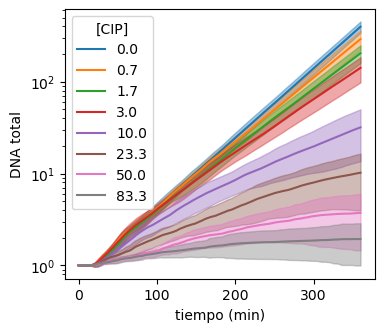

In [28]:
fig = plt.figure(figsize = (4, 3.5))
tab20 = mpl.colormaps['tab20']

# plot de 8 de las curvas de crecimiento
for i in np.linspace(0,len(ks)-1,8, dtype = int):
    plt.plot(np.array(range(Nsteps))*dt, (sim[i]+1000)/1000, label = f'{round(ks[i]/q_minutes,1)}', color = tab20(i))
    plt.fill_between(np.array(range(Nsteps))*dt, (extra[i][-2]+1000)/1000, (extra[i][-1]+1000)/1000, color = tab20(i), alpha = 0.4)

plt.yscale('log')
plt.xlabel('tiempo (min)')
plt.ylabel('DNA total')
plt.legend(title = '[cips]')
plt.show()

Cálculo de tasas de crecimiento + gráfica comparando cada simulación con su ajuste exponencial:

In [ ]:
Vf = 30000
dt = Nbp/(Lo*Vf) 
Nsteps = math.ceil(Tf/dt)

sim = read_list('sim-2712-vf30k')
ks = read_list('ks-2712-vf30k')
extra = read_list('extra-2712-vf30k')
ks = np.array([round(ks[i]/q_minutes, 1) for i in range(len(ks))])

rates_df3, rates_avg3, curve_avg3 = plot_growth_rate(sim, ks, extra)

In [ ]:
Vf = 60000
dt = Nbp/(Lo*Vf) 
Nsteps = math.ceil(Tf/dt)

sim = read_list('sim-1111-vf60k')
ks = read_list('ks-1111-vf60k')
extra = read_list('extra-1111-vf60k')
ks = np.array([round(ks[i]/q_minutes, 1) for i in range(len(ks))])

rates_df6, rates_avg6, curve_avg6 = plot_growth_rate(sim, ks, extra)

In [39]:
write_list(curve_avg6, 'growth-rates-vf60k')

Done writing list into a binary file


Gráfica de tasas de crecimiento:

Text(0, 0.5, 'tasa de crecimiento')

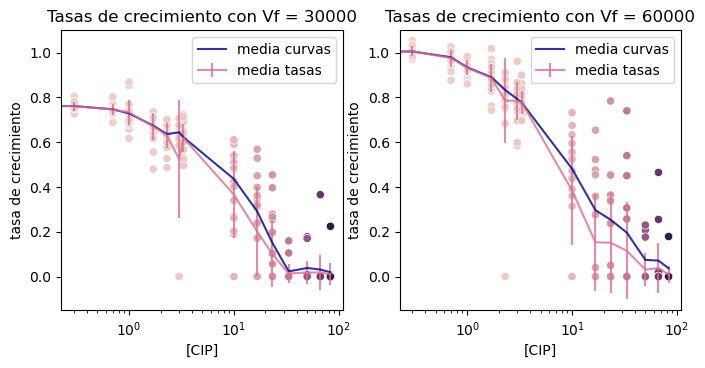

In [24]:
fig = plt.figure(figsize = (8,8))

# datos con vf = 30000 ----------------------------------------
ax1 = plt.subplot(2, 2, 1)

# scatterplot con todas las tasas de crecimiento para cada [cip]
sns.scatterplot(data=rates_df3, x='cip', y='growth rate', hue='cip', legend = False)
# plot con la media de las tasas e intervalos de error +- 1 desviación típica
ax1.errorbar(x=ks, y=rates_avg3[:,0], yerr=rates_avg3[:,1], alpha = 0.8, color = 'palevioletred', label = 'media tasas')
# plot con las tasas de crecimiento para la curva promedio para cada [cip]
ax1.plot(ks, curve_avg3, color = 'darkblue', alpha = 0.8, label = 'media curvas')

# general
ax1.legend()
ax1.set_ylim([-0.15, 1.1])
ax1.set_xscale('log')
ax1.set_title('Tasas de crecimiento con Vf = 30000')
ax1.set_xlabel('[CIP]')
ax1.set_ylabel('tasa de crecimiento')

# datos con vf = 60000 ----------------------------------------
ax2 = plt.subplot(2, 2, 2)

# scatterplot con todas las tasas de crecimiento para cada [cip]
sns.scatterplot(data=rates_df6, x='cip', y='growth rate', hue='cip', legend = False)
# plot con la media de las tasas e intervalos de error +- 1 desviación típica
ax2.errorbar(x=ks, y=rates_avg6[:,0], yerr=rates_avg6[:,1], alpha = 0.8, color = 'palevioletred', label = 'media tasas')
# plot con las tasas de crecimiento para la curva promedio para cada [cip]
ax2.plot(ks, curve_avg6, color = 'darkblue', alpha = 0.8, label = 'media curvas')

# general
ax2.legend()
ax2.set_ylim([-0.15, 1.1])
ax2.set_xscale('log')
ax2.set_title('Tasas de crecimiento con Vf = 60000')
ax2.set_xlabel('[CIP]')
ax2.set_ylabel('tasa de crecimiento')

Text(0, 0.5, 'tasa de crecimiento')

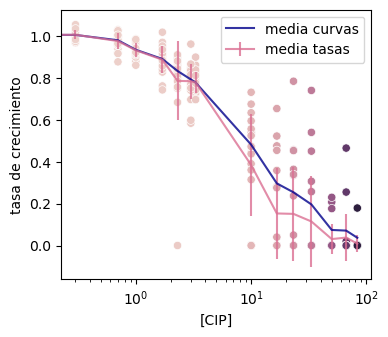

In [ ]:
# lo mismo que la figura anterior, pero solo con los datos de vf = 60000
fig = plt.figure(figsize = (4, 3.5))

sns.scatterplot(data=rates_df6, x='cip', y='growth rate', hue='cip', legend = False)
plt.errorbar(x=ks, y=rates_avg6[:,0], yerr=rates_avg6[:,1], alpha = 0.8, color = 'palevioletred', label = 'media tasas')
plt.plot(ks, curve_avg6, color = 'darkblue', alpha = 0.8, label = 'media curvas')

plt.legend()
plt.xscale('log')
plt.xlabel('[CIP]')
plt.ylabel('tasa de crecimiento')

Text(0, 0.5, 'tasa de crecimiento')

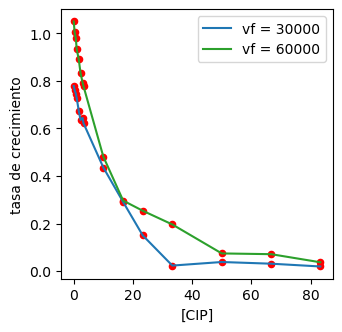

In [ ]:
fig = plt.figure(figsize = (3.5, 3.5))

# plot vf = 30000
plt.plot(ks, curve_avg3, label = 'vf = 30000')
plt.scatter(ks, curve_avg3, color = 'red', s=20)
# plot vf = 60000
plt.plot(ks, curve_avg6, color = 'tab:green', label = 'vf = 60000')
plt.scatter(ks, curve_avg6, color = 'red', s=20)

# general
plt.legend()
plt.xlabel('[CIP]')
plt.ylabel('tasa de crecimiento')

Simulaciones para replicar gráfica 3.A (k = 0.1, k = 0.6):

In [ ]:
# no ejecutar (tarda mucho)
# los datos están en 'data-figura3A'
ks = [0.1, 0.6]
data = []

for k in ks:
    aux = []
    for i in range(10):
        print(f'{i}------------------------------')
        lista = [{'forks' : np.array([start]), 'next_fork' : np.random.normal(step_Tfork, step_std), 'gyrases' : [[], []], 'n_gyr' : 0}] 
        n, gyr, dna = model(lista, start, terminus, step_Tfork, step_std, step_Tgyr, k*dt, p_kill, Nsteps)
        aux.append([n, gyr, dna, lista])
    data.append(aux)

In [ ]:
# write_list(data, 'data-figura3A')
data = read_list('data-figura3A')

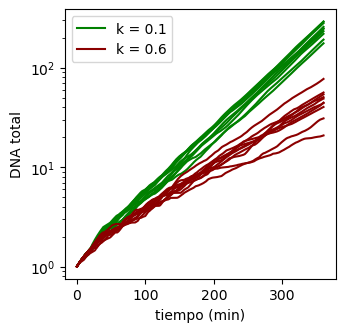

In [ ]:
plt.figure(figsize=(3.5, 3.5))

# plot de simulaciones con k = 0.1
plt.plot(np.array(range(Nsteps))*dt, np.array(data[0][0][2])/1000, color = 'green', label = 'k = 0.1')
for i in data[0][1:]:
    plt.plot(np.array(range(Nsteps))*dt, np.array(i[2])/1000, color = 'green')

# plot de simulaciones con k = 0.6
plt.plot(np.array(range(Nsteps))*dt, np.array(data[1][0][2])/1000, color = 'darkred', label = 'k = 0.6')
for j in data[1][1:]:
    plt.plot(np.array(range(Nsteps))*dt, np.array(j[2])/1000, color = 'darkred')

plt.yscale('log')
plt.ylabel('DNA total')
plt.xlabel('tiempo (min)')
plt.legend()
plt.show()

## Parte 2: primer modelo de ecuaciones diferenciales

### 2.1 : Modelo

In [176]:
# parámetros
a = 199
b = 106/a 
cips = [0, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]

# sistema
def mod_dif(t, x, a, b, cip):
    dxdt = np.zeros(2)
    dxdt[0] = b/(1+(cip*x[1]))*x[1] - x[0]
    dxdt[1] = a*x[0] - cip*x[1]
    return dxdt

# punto de equilibrio
def p_eq(a, b, cip):
    if cip == 0:
        return -1, -1
    else:
        return b/cip - 1/a, (a*b)/(cip**2) - (1/cip)

### 2.2 : Solución numérica

Resolver ecuaciones con scipy.integrate.solve_ivp:

In [177]:
sols = []

# para cada concentración de cip de la lista:
for cip in cips:
    # condición inicial
    x0 = (0, 0.001)

    # solución EDO
    x = solve_ivp(mod_dif, [0, 10], x0, args = (a, b, cip))
    n = np.array(x['y'], dtype=float) 
    t = np.array(x['t'], dtype=float)
    sols.append((t,n))

Gráfica de las soluciones:

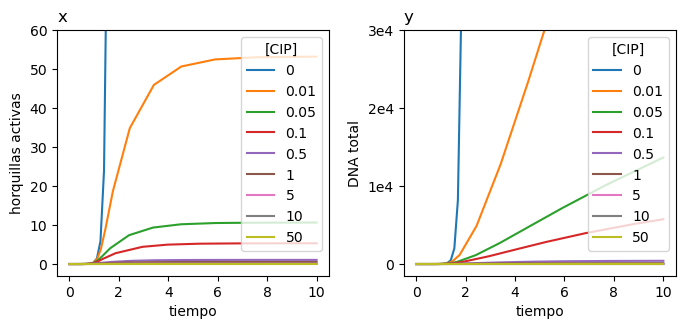

In [179]:
fig = plt.figure(figsize = (7,6))

# plot soluciones variable x
ax1 = plt.subplot(2, 2, 1)
for i, (time, sol) in enumerate(sols):
    ax1.plot(time, sol[0], label = f'{cips[i]}')

ax1.set(xlabel='tiempo', ylabel='horquillas activas')
ax1.set_ylim(top = 60, bottom = -5*60/100)
ax1.set_title('x', loc = 'left')
ax1.legend(loc = 'upper right', title = '[CIP]')

# plot soluciones variable y
ax2 = plt.subplot(2, 2, 2)
for i, (time, sol) in enumerate(sols):
    ax2.plot(time, sol[1], label = f'{cips[i]}')

ax2.set(xlabel='tiempo', ylabel='DNA total')
ax2.legend(loc = 'upper right', title = '[CIP]')
ax2.set_ylim(top = 30000, bottom = -5*30000/100)
ax2.set_title('y', loc = 'left')
ax2.set_yticks(ticks = [0, 10000, 20000, 30000], labels = ['0', '1e4', '2e4', '3e4'])

fig.tight_layout()

### 2.3 : Puntos de equilibrio

Diagrama de fases:

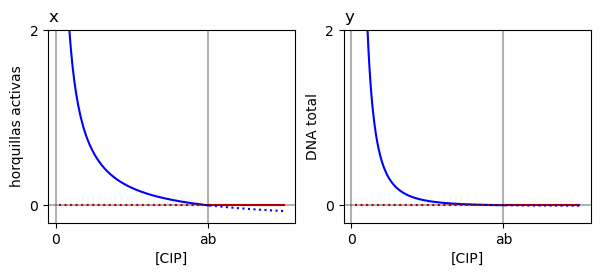

In [180]:
a = 5
b = 40/a
cip_list = np.linspace(1, 60, 600) #[i/10 for i in range(1, 600)]

xs = []
ys = []
for cip in cip_list:
    x, y = p_eq(a, b, cip)
    xs.append(x)
    ys.append(y)
    
fig, axs = plt.subplots(1, 2, figsize = (7, 2.5))

# gráficas puntos de equilibrio variable x
axs[0].plot(cip_list[:400], xs[:400], color = 'blue')
axs[0].plot(cip_list[401:], np.zeros(len(cip_list[401:])), color = 'red')
axs[0].plot(cip_list[:400], np.zeros(len(cip_list[:400])), linestyle = 'dotted', color = 'red')
axs[0].plot(cip_list[401:], xs[401:], linestyle = 'dotted', color = 'blue')

# ejes y línea vertical en cip = a*b
axs[0].axvline(0, color = 'black', alpha = 0.3)
axs[0].axhline(0, color = 'black', alpha = 0.3)
axs[0].axvline(40, color = 'black', alpha = 0.3)
# axs[0].annotate('cip = a*b', (41, 0.8), alpha = 0.5)

axs[0].set_title('x', loc = 'left')
axs[0].set_xlabel('[CIP]')
axs[0].set_ylabel('horquillas activas')
axs[0].set_ylim((-0.2, 2))
axs[0].set_xticks(ticks = [0, 40], labels = ['0', 'ab'])
axs[0].set_yticks(ticks=[0, 2])

# --------------------------------------------------

# gráficas puntos de equilibrio variable y
axs[1].plot(cip_list[:400], ys[:400], color = 'blue')
axs[1].plot(cip_list[401:], np.zeros(len(cip_list[401:])), color = 'red')
axs[1].plot(cip_list[:400], np.zeros(len(cip_list[:400])), linestyle = 'dotted', color = 'red')
axs[1].plot(cip_list[401:], ys[401:], linestyle = 'dotted', color = 'blue')

# ejes y línea vertical en cip = a*b
axs[1].axvline(0, color = 'black', alpha = 0.3)
axs[1].axhline(0, color = 'black', alpha = 0.3)
axs[1].axvline(40, color = 'black', alpha = 0.3)
# axs[1].annotate('cip = a*b', (41, 0.8), alpha = 0.5)

axs[1].set_title('y', loc = 'left')
axs[1].set_xlabel('[CIP]')
axs[1].set_ylabel('DNA total')
axs[1].set_ylim((-0.2, 2))
axs[1].set_xticks(ticks = [0, 40], labels = ['0', 'ab'])
axs[1].set_yticks(ticks=[0, 2])

Diagrama de flujo:

In [ ]:
# sistema EDOs simplificado
def mod_simpl(x, y):
    dxdt = b/(1+(cip*y))*y - x
    dydt = a*x - cip*y
    return dxdt, dydt

fig, axs = plt.subplots(2, 2, figsize = (10, 10))

# variables 
a = 27
b = 149/a
cip_list = [1, 2, 5, 10]
N = 20

# diagrama de flujo para cuatro valores de cip
for cip, ax in zip(cip_list, axs.flat):
    xi = 0; xf = 6
    yi = 0; yf = 175 
    x = np.linspace(xi, xf, N)
    y = np.linspace(yi, yf, N)
    X,Y = np.meshgrid(x, y)
    U, V = mod_simpl(X,Y)

    ax.quiver(X, Y, U, V, color='k')
    # ax.grid(True)
    ax.set_title(f'cip = {cip}')
    ax.axvline(0, color = 'black', alpha = 0.5)
    ax.axhline(0, color = 'black', alpha = 0.5)
    ax.scatter(*p_eq(a, b, cip))

### 2.4 : Ajuste del punto de equilibrio x a las tasas de crecimiento del modelo de autómatas

Recuperar los datos:

In [125]:
sim = read_list('sim-1111-vf60k')
ks = read_list('ks-1111-vf60k')
extra = read_list('extra-1111-vf60k')
rates = read_list('growth-rates-vf60k')

cip_list = np.array(ks)/q_minutes

Ajuste por mínimos cuadrados, de todos los datos y de los últimos 7:

In [126]:
# función de error MSE
def error(ks, rates, a, ab):
    err = 0
    for k, rate in zip(ks, rates):
        predicted_value, _ = p_eq(a, ab/a, k)
        target_value = rate
        err += (predicted_value-target_value)**2
    return err

# función que itera sobre espacio de parámetros hasta hallar MSE mínimo
def best_params(cip_list, rates, parameters, title):
    errors = []
    lowest = 9999
    for i in parameters:
        err = error(cip_list, rates, i['a'], i['ab'])
        errors.append(err)
        if err < lowest:
            lowest = err

    # imprimir error mínimo y conjunto óptimo de parámetros
    print(f'{title}----------\nsmallest error = {lowest}')
    print(f'index = {errors.index(lowest)}')
    print(f'best params : {parameters[errors.index(lowest)]}')

    # devuelve conjunto óptimo de parámetros y MSE mínimo
    return parameters[errors.index(lowest)]['a'], parameters[errors.index(lowest)]['ab']/parameters[errors.index(lowest)]['a']


# ajuste con todos los datos ------------------------------

# espacio paramétrico
param_grid_best = {'a': range(100,200), 'ab': range(50,175)}
# param_grid_best = {'a': range(10,31), 'ab': range(50, 150)}
parameters = ParameterGrid(param_grid_best)

params_best = best_params(cip_list[1:], rates[1:], parameters, 'best fit')

# ajuste con últimos 7 puntos ------------------------------

# espacio paramétrico 
param_grid_last7 = {'a': range(10,31), 'ab': range(50, 150)}
parameters = ParameterGrid(param_grid_last7)

params_last7 = best_params(cip_list[-7:], rates[-7:], parameters, 'last 7')

best fit----------
smallest error = 2.3801159145715527
index = 12431
best params : {'ab': 106, 'a': 199}
last 7----------
smallest error = 0.00934562556119855
index = 1799
best params : {'ab': 149, 'a': 27}


Gráfica del ajuste:

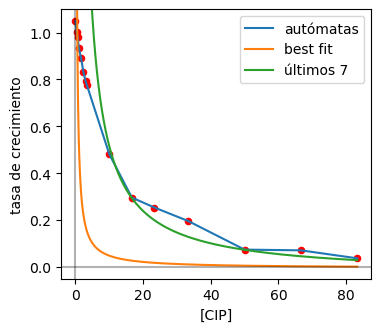

In [152]:
fig = plt.figure(figsize = (4, 3.5))

# modelo de autómatas
plt.plot(cip_list, rates, label = 'autómatas')
plt.scatter(cip_list, rates, color = 'red', s=20)

# punto de equilibrio modelo EDOs
for (a, b), label in zip([params_best, params_last7], ['best fit', 'últimos 7']):
    xs = []
    ys = []
    for cip in np.linspace(0.01, cip_list[-1], 1000):
        x, y = p_eq(a, b, cip)
        xs.append(x)
        ys.append(y)

    plt.plot(np.linspace(0.01, cip_list[-1], 1000), xs, label = f'{label}')

# general 
plt.axvline(0, color = 'black', alpha = 0.3)
plt.axhline(0, color = 'black', alpha = 0.3)
plt.ylim([-0.05,rates[0]+0.05])

plt.xlabel('[CIP]')
plt.ylabel('tasa de crecimiento')
plt.legend()

## Parte 3: segundo modelo de ecuaciones diferenciales

### 3.1 : Modelo

In [4]:
# parámetros
a = 12
b = 122/a
d = 116
cips = [0, 1, 5, 10, 20, 30, 50]

# sistema
def mod_dif2(t, x, a, b, d, cip):
    dxdt = np.zeros(2)
    dxdt[0] = b/(1+(cip*x[1]))*x[1] - x[0]
    dxdt[1] = (a-d*x[1])*x[0] - cip*x[1]
    return dxdt

# punto de equilibrio
def p_eq2(a, b, d, cip):
    return (a*b-cip)/(a*cip+d), (a*b-cip)/(cip**2+b*d)

### 3.2 : Solución numérica

Resolver ecuaciones con scipy.integrate.solve_ivp:

In [184]:
sols = []

# para cada concentración de cip de la lista:
for cip in cips:
    # condición inicial
    x0 = (0, 0.001)

    # solución EDO
    x = solve_ivp(mod_dif2, [0, 5], x0, args = (a, b, d, cip))
    n = np.array(x['y'], dtype=float) 
    t = np.array(x['t'], dtype=float)
    sols.append((t,n))

Gráfica de las soluciones:

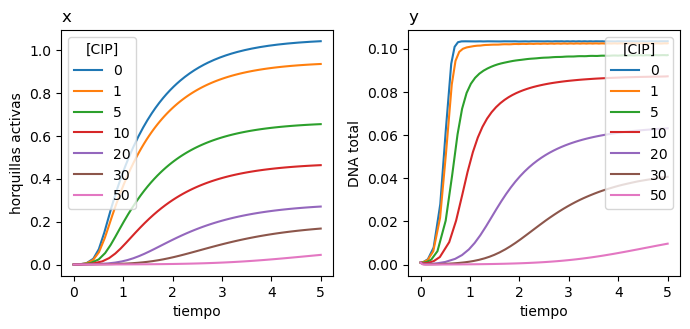

In [186]:
fig = plt.figure(figsize = (7,6))

# plot soluciones variable x
ax1 = plt.subplot(2, 2, 1)
for i, (time, sol) in enumerate(sols):
    ax1.plot(time, sol[0], label = f'{cips[i]}')

ax1.set(xlabel='tiempo', ylabel='horquillas activas')
ax1.set_title('x', loc = 'left')
ax1.legend(title = '[CIP]')

# plot soluciones variable y
ax2 = plt.subplot(2, 2, 2)
for i, (time, sol) in enumerate(sols):
    ax2.plot(time, sol[1], label = f'{cips[i]}')

ax2.set(xlabel='tiempo', ylabel='DNA total')
ax2.legend(loc = 'upper right', title = '[CIP]')
ax2.set_title('y', loc = 'left')

fig.tight_layout()

### 3.3 : Puntos de equilibrio

Diagrama de fases:

In [238]:
c = sp.Symbol('c')
a = 20
b = 40/a
d = 40

sol = float(sp.N(solve((1+c)**2 - (4*d*(a*b -c))/(a*c + d), c)[0]))
print(sol)

5.212003934711964


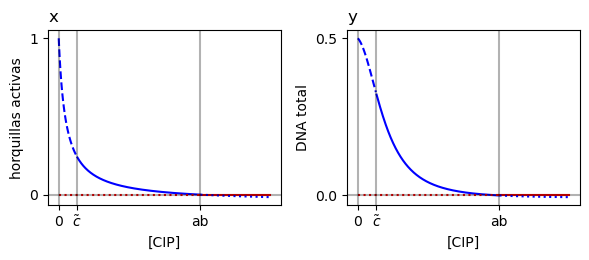

In [257]:
a = 20
b = 40/a
d = 40
cips = np.linspace(0, 60, 600)

xs = []
ys = []
for cip in cips:
    x, y = p_eq2(a, b, d, cip)
    xs.append(x)
    ys.append(y)
    
fig, axs = plt.subplots(1, 2, figsize = (6, 2.7))

# gráficas puntos de equilibrio variable x
axs[0].plot(cips[:math.floor(sol*10)], xs[:math.floor(sol*10)], color = 'blue', linestyle = 'dashed')
axs[0].plot(cips[math.ceil(sol*10):400], xs[math.ceil(sol*10):400], color = 'blue')

axs[0].plot(cips[401:], np.zeros(len(cips[401:])), color = 'red')
axs[0].plot(cips[:400], np.zeros(len(cips[:400])), linestyle = 'dotted', color = 'red')
axs[0].plot(cips[401:], xs[401:], linestyle = 'dotted', color = 'blue')

# ejes y línea vertical en cip = a*b y en cip = sol
axs[0].axvline(0, color = 'black', alpha = 0.3)
axs[0].axhline(0, color = 'black', alpha = 0.3)
axs[0].axvline(40, color = 'black', alpha = 0.3)
axs[0].axvline(sol, color = 'black', alpha = 0.3)

# general
axs[0].set_title('x', loc = 'left')
axs[0].set_xlabel('[CIP]')
axs[0].set_ylabel('horquillas activas')
axs[0].set_xticks(ticks = [0, sol, 40], labels = ['0', r'$\~c$', 'ab'])
axs[0].set_yticks([0, 1])

# --------------------------------------------------

# gráficas puntos de equilibrio variable y
axs[1].plot(cips[:math.floor(sol*10)], ys[:math.floor(sol*10)], color = 'blue', linestyle = 'dashed')
axs[1].plot(cips[math.ceil(sol*10):400], ys[math.ceil(sol*10):400], color = 'blue')

axs[1].plot(cips[401:], np.zeros(len(cips[401:])), color = 'red')
axs[1].plot(cips[:400], np.zeros(len(cips[:400])), linestyle = 'dotted', color = 'red')
axs[1].plot(cips[401:], ys[401:], linestyle = 'dotted', color = 'blue')

# ejes y línea vertical en cip = a*b
axs[1].axvline(0, color = 'black', alpha = 0.3)
axs[1].axhline(0, color = 'black', alpha = 0.3)
axs[1].axvline(40, color = 'black', alpha = 0.3)
axs[1].axvline(sol, color = 'black', alpha = 0.3)

# general
axs[1].set_title('y', loc = 'left')
axs[1].set_xlabel('[CIP]')
axs[1].set_ylabel('DNA total')
axs[1].set_xticks(ticks = [0, sol, 40], labels = ['0', r'$\~c$', 'ab'])
axs[1].set_yticks([0, 0.5])

fig.tight_layout()

Diagrama de flujo:

In [ ]:
# sistema EDOs simplificado
def mod_simpl2(x, y):
    dxdt = b/(1+(cip*y))*y - x
    dydt = (a-d*y)*x - cip*y
    return dxdt, dydt

fig, axs = plt.subplots(2, 2, figsize = (10, 10))

# variables 
a = 12
b = 122/a
d = 116
cips = [0, 10, 50, 100]
N = 20

# diagrama de flujo para cuatro valores de cip
for cip, ax in zip(cips, axs.flat):
    xi = 0; xf = 1.5
    yi = 0; yf = 0.2
    x = np.linspace(xi, xf, N)
    y = np.linspace(yi, yf, N)
    X,Y = np.meshgrid(x, y)
    U, V = mod_simpl2(X,Y)

    ax.quiver(X, Y, U, V, color='k')
    # ax.grid(True)
    ax.set_title(f'cip = {cip}')
    ax.axvline(0, color = 'black', alpha = 0.5)
    ax.axhline(0, color = 'black', alpha = 0.5)
    ax.scatter(*p_eq2(a, b, d, cip))

### 3.4 : Ajuste del punto de equilibrio x a las tasas de crecimiento del modelo de autómatas

Recuperar los datos:

In [271]:
sim = read_list('sim-1111-vf60k')
ks = read_list('ks-1111-vf60k')
extra = read_list('extra-1111-vf60k')
rates = read_list('growth-rates-vf60k')

cip_list = np.array(ks)/q_minutes

Ajuste por mínimos cuadrados:

In [ ]:
# definir estimador personalizado
class Estimador(BaseEstimator, RegressorMixin):
    def __init__(self, a=1, ab=1, d=1):
        # Definimos tres parámetros a ajustar
        self.a = a
        self.ab = ab
        self.d = d

    def fit(self, X, y):
        # ajusta el modelo (en este caso no hacemos nada)
        return self

    def predict(self, X):
        # predice usando el modelo ajustado
        prediction = (self.ab - X) / (self.a * X + self.d)
        prediction[prediction < 0] = 0
        return prediction

    def score(self, X, y):
        # devuelve el score (MSE)
        predictions = self.predict(X)
        return -mean_squared_error(y, predictions)

In [ ]:
# crear el estimador
estimador = Estimador()

# definir espacio de parámetros
param_grid = {'a': range(5, 15), 'ab': range(70, 130), 'd': range(95, 120)}

# usar GridSearchCV para encontrar el mejor conjunto de parámetros
grid_search = GridSearchCV(estimator=estimador, param_grid=param_grid, cv=5)
grid_search.fit(cip_list, rates)

print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor score (MSE):", np.abs(grid_search.best_score_))

Mejor conjunto de parámetros: {'a': 12, 'ab': 122, 'd': 116}
Mejor score (MSE): 0.00023119997624378952


Gráfica del ajuste:

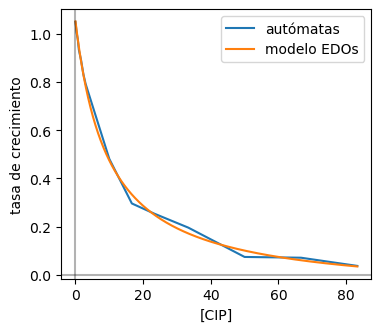

In [273]:
fig = plt.figure(figsize = (4, 3.5))

# modelo de autómatas
plt.plot(cip_list, rates, label = 'autómatas')

# punto de equilibrio modelo EDOs
xs = []
ys = []
for cip in np.linspace(0, cip_list[-1], 1000):
    x, y = p_eq2(12, 122/12, 116, cip)
    xs.append(x)
    ys.append(y)

plt.plot(np.linspace(0, cip_list[-1], 1000), xs, label = 'modelo EDOs')

# general 
plt.axvline(0, color = 'black', alpha = 0.3)
plt.axhline(0, color = 'black', alpha = 0.3)

plt.xlabel('[CIP]')
plt.ylabel('tasa de crecimiento')
plt.legend()

### 3.5-A : Procesado de datos experimentales

Cargar datos experimentales:

In [1]:
def convertDATA(df,dosis):
    
    dosis['Unnamed: 0'] = dosis['Unnamed: 0'].astype(str)
    dic_dosis = dosis.set_index('Unnamed: 0')['C (ug/ml)'].to_dict()

    df1 = df.rename(columns={'E1':'EControl-','F1':'FControl-','G1':'GControl-','H1':'HControl-'})
    
    df1 = pd.melt(df1, id_vars=['Date and Time', 'Duration (Hours)', 'Duration (Minutes)','UNIX Timestamp', 'Air Temp '],
                     var_name='well', value_name='OD')
    
    df1['replica'] = df1['well'].str[0] #identificamos la fila del pocillo
    df1['Dosis']   = df1['well'].str[1:] #identificamos la columna del pocillo
    df1['Dosis']   = df1['Dosis'].replace(dic_dosis) #Elegimos el orden de las dosis en los pocillos
    df1 = df1[df1['Dosis']!='Control-']
    df1['Dosis'] = df1['Dosis']*1000

    df1 = df1.dropna()
    return df1

In [7]:
dosis_cip = pd.read_excel('experimental/cip_pipeteo_dose_response_141102024.xlsx')
df_cip = pd.read_csv('experimental/placaCIP_protocolo12tubos_dosisinicial_0.03ug-ml_M9URI_stratus2_incubdcha_151124.csv', skiprows=11)

df_cip = convertDATA(df_cip, dosis_cip)
df_cip = df_cip[df_cip['Duration (Hours)'] <= 24]
df_cip = df_cip[df_cip['Dosis'] != 'Control-']

df_mean = df_cip.groupby(['Dosis', 'Duration (Hours)']).mean(numeric_only=True).reset_index()
dosis = np.array(df_cip['Dosis'].sort_values().unique())

Gráfica curvas dosis-respuesta medias:

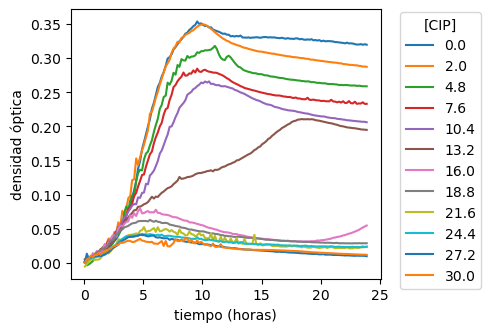

In [337]:
fig = plt.figure(figsize = (4, 3.5))
for cip, data in df_mean.groupby('Dosis'):
    plt.plot(data['Duration (Hours)'], data['OD'], label = f'{round(cip, 1)}')
plt.xlabel('tiempo (horas)')
plt.ylabel('densidad óptica')
plt.legend(title = '[CIP]', bbox_to_anchor=(1.04, 1.015))
plt.show()

Hallar tasas de crecimiento y capacidad de carga datos experimentales:

In [8]:
# función que vamos a ajustar a los datos
def resources_eq(t,x,mu,ro,C):
    return mu*ro*x[0]*(C-x[0])/(ro+C-x[0])

In [286]:
def best_parameters(data):
    '''
    Halla el mejor set de parámetros para ajustar una curva dosis-respuesta.
    '''
    n,m,z = 60,30,20

    msmant = 9999
    minerr = 0.00005
    mu_best, ro_best, C_best = 0,0,0
    
    for mu in np.linspace(0.05,20,n):
        for ro in np.linspace(0.01,10,m):
            for C in np.linspace(0.05,0.5,z):
            
                solution = solve_ivp(
                    resources_eq,
                    (data['Duration (Hours)'].min(), data['Duration (Hours)'].max()),
                    [0.01],
                    t_eval= data['Duration (Hours)'].values,
                    method='LSODA',
                    args = (mu,ro,C)
                )
                MSM = np.mean((solution.y[0] - data['OD'].values)**2)
                
                if MSM < msmant:
                    msmant = MSM
                    mu_best, ro_best, C_best = mu, ro, C
                
                if msmant < minerr:
                    return mu_best, ro_best, C_best, msmant
                
    return mu_best, ro_best, C_best, msmant

In [ ]:
# no ejecutar (tarda mucho)
# los datos están en 'df_parametros.xlsx'
df_parametros = pd.DataFrame(columns=['well','mu','ro','C','MSE','Dosis'])

for inf, data in df_cip.groupby(['well','Dosis']):
    mu_best, ro_best, C_best, msmant = best_parameters(data)
    df_parametros = pd.concat([df_parametros, pd.DataFrame({'well':[inf[0]],
                                                            'mu':[mu_best],
                                                            'ro':[ro_best],
                                                            'C':[C_best],
                                                            'MSE':[msmant],
                                                            'Dosis':[inf[1]],
                                                           })])
    print(inf, mu_best, ro_best, C_best, msmant)
df_parametros

In [ ]:
# no ejecutar
df_parametros.to_excel('df_parametros-ejemplo.xlsx')

In [9]:
df_parametros = pd.read_excel('df_parametros.xlsx')
df_parametros['growth rate'] = df_parametros['ro']*df_parametros['mu']*df_parametros['C']/(df_parametros['ro'] + df_parametros['C'])
df_parametros_mean = df_parametros.groupby('Dosis').mean(numeric_only=True).reset_index()

Gráfica del ajuste de la función resources_eq a los datos:

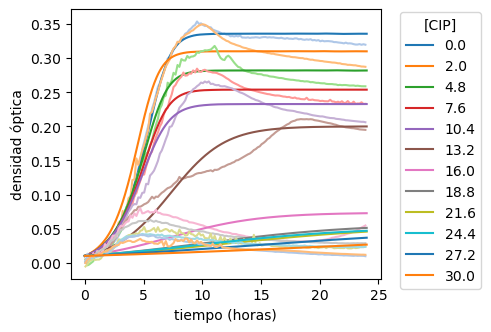

In [ ]:
fig = plt.figure(figsize = (4, 3.5))
tab20 = mpl.colormaps['tab20']

for j, d in enumerate(dosis):
    # plot datos experimentales
    plt.plot(df_mean[df_mean['Dosis'] == d]['Duration (Hours)'], df_mean[df_mean['Dosis'] == d]['OD'], color = tab20((2*j+1)%20))

    # intervalo de tiempo para la integración
    t_span = (0, 24) 
    t_eval = np.linspace(t_span[0], t_span[1], 500)

    # parámetros óptimos
    args = [df_parametros_mean[df_parametros_mean['Dosis'] == d]['mu'],
            df_parametros_mean[df_parametros_mean['Dosis'] == d]['ro'],
            df_parametros_mean[df_parametros_mean['Dosis'] == d]['C']]
    
    # solución EDO
    solution = solve_ivp(
        resources_eq,
        t_span,
        [0.01],
        t_eval=t_eval,
        method='RK45', 
        args = args
    )

    # plot EDO
    plt.plot(solution.t, solution.y[0], label=f'{round(d, 1)}', color = tab20((2*j)%20))

plt.legend(title = '[CIP]', bbox_to_anchor=(1.04, 1.015))
plt.ylabel('densidad óptica')
plt.xlabel('tiempo (horas)')
plt.show()

### 3.5-B : Ajuste del modelo de EDOs a los datos experimentales

Ajuste de tasa de crecimiento y capacidad de carga

In [10]:
df_parametros_median = df_parametros.groupby('Dosis').median(numeric_only=True)
growth_rate = np.array(df_parametros_median['growth rate'])
carrying_capacity = np.array(df_parametros_median['C'])
c = np.array(df_parametros['Dosis'].sort_values().unique())

In [329]:
param_grid_x = {'a': np.linspace(0.01, 1, 100), 'ab': np.linspace(20, 30, 100), 'd': np.linspace(30, 40, 100)}
param_grid_y = {'a': np.linspace(0.4, 0.5, 100), 'ab': np.linspace(40, 80,  100), 'd': np.linspace(1, 1.5, 100)} 
parameters_x = ParameterGrid(param_grid_x)
parameters_y = ParameterGrid(param_grid_y)

def x_eq(cip, a, b, d):
    if cip < a*b:
        return (a*b-cip)/(a*cip+d)
    else:
        return 0
def y_eq(cip, a, b, d):
    if cip < a*b:
        return (a*b-cip)/(cip**2+b*d)
    else: 
        return 0

def error(func, ks, rates, a, ab, d):
    err = 0
    for j in range(len(ks)):
        predicted_value = func(ks[j], a, ab/a, d)
        target_value = rates[j]
        err += (predicted_value-target_value)**2
    return err

# best fit x (growth rate) ------------------------------------------
errors = []
lowest = 9999
for i in parameters_x:
    err = error(x_eq, c, growth_rate, i['a'], i['ab'], i['d'])
    errors.append(err)
    if err < lowest:
        lowest = err

best_x = parameters_x[errors.index(lowest)]
print(f'x fit\nbest params : {best_x}, error = {lowest}')

# best fit y (carrying capacity) ------------------------------------
errors = []
lowest = 9999
for i in parameters_y:
    err = error(y_eq, c, carrying_capacity, i['a'], i['ab'], i['d'])
    errors.append(err)
    if err < lowest:
        lowest = err

best_y = parameters_y[errors.index(lowest)]
print(f'y fit\nbest params : {best_y}, error = {lowest}')

# para growth rate: 
# x best : a = 0.01, b = 26.56/a, d = 36.76,  MSE = 0.061053821974809394
# para C (carrying capacity):
# y best : a = 0.48, b = 69.09/a, d = 1.43, MSE = 0.011825679975237202

x fit
best params : {'d': 36.76767676767677, 'ab': 26.565656565656568, 'a': 0.01}, error = 0.061053821974809394
y fit
best params : {'d': 1.4292929292929293, 'ab': 69.0909090909091, 'a': 0.4797979797979798}, error = 0.011825679975237202


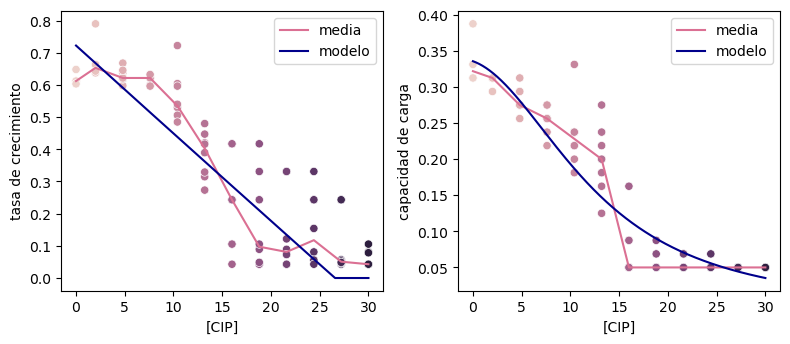

In [359]:
# modelo diferencial
CIP = np.linspace(0, c[-1], 1000)

xs = []
ys = []
for cip in CIP:
    x = x_eq(cip, best_x['a'], best_x['ab']/best_x['a'], best_x['d'])
    y = y_eq(cip, best_y['a'], best_y['ab']/best_y['a'], best_y['d'])
    xs.append(x)
    ys.append(y)


# gráfica
fig = plt.figure(figsize = (8, 6.5))
ax1 = plt.subplot(2, 2, 1)
sns.scatterplot(data=df_parametros, x='Dosis', y='growth rate',hue='Dosis', legend = False)
# plt.scatter(c, vals, label = 'experimental', color = 'black')
ax1.plot(c, df_parametros_median['growth rate'], color = 'palevioletred', label = 'media')
ax1.plot(CIP, xs, label = f'modelo', color = 'darkblue')
ax1.set_xlabel('[CIP]')
ax1.set_ylabel('tasa de crecimiento')
ax1.legend(loc = 'upper right')

ax2 = plt.subplot(2, 2, 2)
sns.scatterplot(data=df_parametros, x='Dosis', y='C',hue='Dosis', legend = False)
ax2.plot(c, df_parametros_median['C'], color = 'palevioletred', label = 'media')
ax2.plot(CIP, ys, label = f'modelo', color = 'darkblue')
ax2.set_xlabel('[CIP]')
ax2.set_ylabel('capacidad de carga')
ax2.legend()

fig.tight_layout()

# general 
# fig.suptitle('Crecimiento modelo 2')
# plt.xlabel('[CIP]')
# plt.ylabel('Tasa de crecimiento')
# plt.axvline(0, color = 'black', alpha = 0.3)
# plt.axhline(0, color = 'black', alpha = 0.3)
# plt.legend()

Ajuste de curvas de crecimiento

In [11]:
# ajuste de cada curva 
viridis = mpl.colormaps['viridis'].resampled(12)

def best_parameters(data, cip, k):

    n,m,z = 40, 40, 20
    M = np.zeros((n,m,z))

    msmant = 9999
    minerr = 0.00005 # es demasiado grande, hay varios que con el primer set que prueban ya tienen 0.00015... sobretodo con cip >> 0
    a_best, ab_best, d_best = 0,0,0
    
    for i,a in enumerate(np.linspace(0.01, 110, n)):
        for j,ab in enumerate(np.linspace(0.1, 120, m)):
            for h,d in enumerate(np.linspace(0.05, 40,z)):
                MSM = 0
                solution = solve_ivp(
                        model,
                        (data['Duration (Hours)'].min(), data['Duration (Hours)'].max()),
                        [0, 0.01],
                        t_eval= np.unique(data['Duration (Hours)'].values),
                        method='BDF', 
                        args = (a, ab, d, cip)
                    )
                for row in ['A','B','C','D','E','F','G','H']:
                    if all([row == 'E',cip == 0]):
                        break
                    # mse = np.mean((solution.y[1] - data[data['replica']==f'{row}']['OD'].values)**2)
                    mse = np.mean((solution.y[1][:73] - data[data['replica']==f'{row}']['OD'].values[:73])**2)
                    MSM += mse
                
                if MSM < msmant:
                    #plt.plot(solution.t, solution.y[0])
                    #plt.scatter(data['Duration (Hours)'], data['OD filtered'],color='red')
                    #plt.title(str(mu)+' '+str(ro))
                    #plt.show()
                    #print(MSM)
                    msmant = MSM
                    # print(msmant)
                    a_best, ab_best, d_best = a, ab, d

                M[i,j,h] = MSM

                if msmant < minerr:
                    return a_best, ab_best, d_best, msmant
    
    plt.plot(np.unique(data['Duration (Hours)'].values), data[data['replica']=='A']['OD'].values, color = viridis(k)) 
    solution = solve_ivp(
                        model,
                        (data['Duration (Hours)'].min(), data['Duration (Hours)'].max()),
                        [0, 0.01],
                        t_eval= np.unique(data['Duration (Hours)'].values),
                        method='BDF', 
                        args = (a_best, ab_best, d_best, cip)
                    )
    plt.plot(solution.t, solution.y[1], color = viridis(k))
    return a_best, ab_best, d_best, msmant

In [ ]:
# no ejecutar
# datos en 'ajuste-edos2-peak-0801.xlsx' y 'ajuste-edos2-full.xlsx'
df_parametros = pd.DataFrame(columns=['a','ab','d','MSE','Dosis'])

for i, (inf, data) in enumerate(df_cip.groupby('Dosis')):
    a_best, ab_best, d_best, msmant = best_parameters(data, inf*1000, i)
    df_parametros = pd.concat([df_parametros, pd.DataFrame({'a':[a_best],
                                                            'ab':[ab_best],
                                                            'd':[d_best],
                                                            'MSE':[msmant],
                                                            'Dosis':[inf],
                                                           })], ignore_index=True)
    print(inf, a_best, ab_best, d_best, msmant)
df_parametros

In [12]:
# ajuste de todas las curvas
def best_params(df):
    # profundidad de la búsqueda (nº parámetros)
    n,m,z = 10, 10, 10

    msmant = 9999
    a_best, ab_best, d_best = 0,0,0

    # sistema de ecuaciones
    def model(t, x, a, ab, d, cip):
        dxdt = np.zeros(2)
        dxdt[0] = (ab/a)/(1+(cip*x[1]))*x[1] - x[0]
        dxdt[1] = (a-d*x[1])*x[0] - cip*x[1]
        return dxdt
    
    # espacio de parámetros
    for a in np.linspace(0.1, 0.6, n):
        for ab in np.linspace(40, 55, m):
            for d in np.linspace(1.3, 1.55,z):
                MSM = 0
                
                # para cada dosis de cip y set de datos correspondiente: 
                for cip, data in df.groupby('Dosis'):
                    # resolver EDO con cada set de parámetros
                    solution = solve_ivp(
                            model,
                            t_span=(data['Duration (Hours)'].min(), data['Duration (Hours)'].max()),
                            y0=[0, 0.01],
                            t_eval= np.unique(data['Duration (Hours)'].values),
                            method='BDF', 
                            args = (a, ab, d, cip*1000)
                        )
                    # calcular distancia a la curva experimental y sumarla al error
                    mse = np.mean((solution.y[1] - data['OD'].values)**2) # [36:73]
                    MSM += mse
                
                # si el error obtenido es menor que el mínimo encontrado, cambiar set óptimo de parámetros
                if MSM < msmant:
                    msmant = MSM
                    a_best, ab_best, d_best = a, ab, d
                
    return a_best, ab_best, d_best, msmant

In [ ]:
# no ejecutar (tarda mucho)
df_mean = df_cip.groupby(['Dosis', 'Duration (Hours)']).mean(numeric_only=True).reset_index()
a_best, ab_best, d_best, msmant = best_params(df_mean)
print(f'a = {a_best}, b = {ab_best}/a, d = {d_best}, MSE = {msmant}')

a = 0.43333333333333335, b = 55.0/a, d = 1.4666666666666668, MSE = 0.04267313647223608


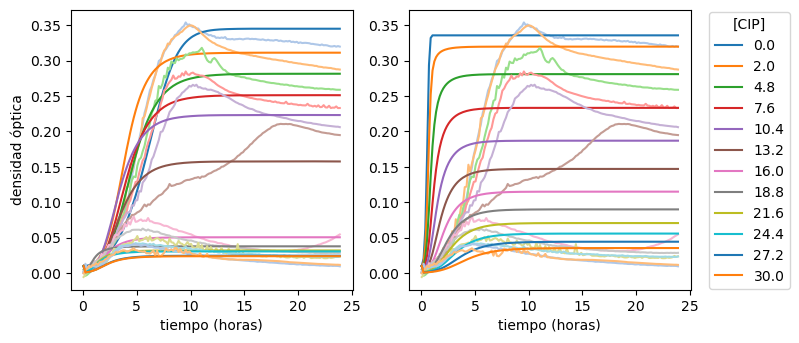

In [41]:
fig = plt.figure(figsize=(8,8))
coolwarm = mpl.colormaps['tab20']
df_parametros = pd.read_excel('ajuste-edos2-full.xlsx', index_col=0)

# plot 1: ajuste por separado
ax1 = plt.subplot(2, 2, 1)
for i, (cip, data) in enumerate(df_mean.groupby('Dosis')):
    # curva media de cada dosis
    ax1.plot(data['Duration (Hours)'], data['OD'], color = coolwarm((2*i+1)%20))

    # parámetros óptimos
    args = (df_parametros[df_parametros['Dosis'] == round(cip,1)]['a'],
            df_parametros[df_parametros['Dosis'] == round(cip,1)]['ab']/df_parametros[df_parametros['Dosis'] == round(cip,1)]['a'],
            df_parametros[df_parametros['Dosis'] == round(cip,1)]['d'],
            cip)

    # Resolución de la ODE
    solution = solve_ivp(
        mod_dif2,
        (data['Duration (Hours)'].min(), data['Duration (Hours)'].max()),
        [0, 0.01],
        t_eval=np.unique(data['Duration (Hours)'].values),
        method='BDF',  
        args=args
    )

    # gráfica de la ODE
    ax1.plot(solution.t, solution.y[1], color = coolwarm((2*i)%20), label = f'{round(cip, 1)}')
ax1.set_xlabel('tiempo (horas)')
ax1.set_ylabel('densidad óptica')
# ax1.legend(title = '[CIP]')

# plot 2: ajuste total
ax2 = plt.subplot(2, 2, 2)
for i, (cip, data) in enumerate(df_mean.groupby('Dosis')):
    
    a_best = 0.48; ab_best = 69.1; d_best = 1.43 # best fit curvas completas

    ax2.plot(data['Duration (Hours)'], data['OD'], color = coolwarm((2*i+1)%20))
    solution = solve_ivp(
                        mod_dif2,
                        t_span=(data['Duration (Hours)'].min(), data['Duration (Hours)'].max()),
                        y0=[0, 0.01],
                        t_eval= np.unique(data['Duration (Hours)'].values),
                        method='BDF', 
                        args = (a_best, ab_best/a_best, d_best, cip)
                        )
    ax2.plot(solution.t, solution.y[1], color = coolwarm((2*i)%20), label = f'{round(cip, 1)}')
ax2.set_xlabel('tiempo (horas)')
# ax2.set_ylabel('tamaño poblacional')
ax2.legend(title = '[CIP]', bbox_to_anchor=(1.04, 1.015))
